In [914]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
from cython import *
from sympy import lambdify
import copy
from functools import *

In [915]:
def real(oper):
    return (oper+oper.conj())/2
def imag(oper):
    return (oper-oper.conj())/2

w = 10,20 wxx = 0.2 T ~ 9600, 4800
w = 10,20 wxx = 0.4 T ~ 2400, 1200
w = 10,20 wxx = 0.8 T ~ 600,  300
w = 5, 20 wxx = 0.4 T ~ 3000, 1500
w = 8, 20 wxx = 0.4 T ~ 2500, 1333
w = 4, 20 wxx = 0.4 T ~ 7600, 1500
w = 2, 20 wxx = 0.4 T ~ 15200,1550
w = 5, 25 wxx = 0.4 T ~ 9600, 1900

# Parameters

In [1138]:
k = 1
w    = [5*2*np.pi*k,6.1*2*np.pi*k]   #w[i] is transition frequency of qubit [i] 
wxx  = 0.05*np.pi*k  #wxx is coupling energy
f    = [0.07*2*np.pi*k,0] #f[i] is amplitude of microwave signal applied to qubit [i] 3
w_rf = [w[1], 0]  #w_rf[i] is frequency of --//--
phi  = [0, 0]  #phi[i] is phase of --//--
N    = [2,2]   #2lvls approximation

In [1139]:
a = 0
b = t_gate = 1*np.pi/wxx/f[0]*abs(w[0]-w[1])
st = 0.01

In [1140]:
args = {'a':a, 'b':b,'st':st, 'w_rf':w_rf[0],'phi':phi[0]}

In [1141]:
time_coeff = "cos(w_rf*t + phi)*0.5*(tanh((t-a)/st) - tanh((t-b)/st))"
tlist_t = 5000
timesteps = 500
tlist = np.linspace(0,tlist_t,timesteps)

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


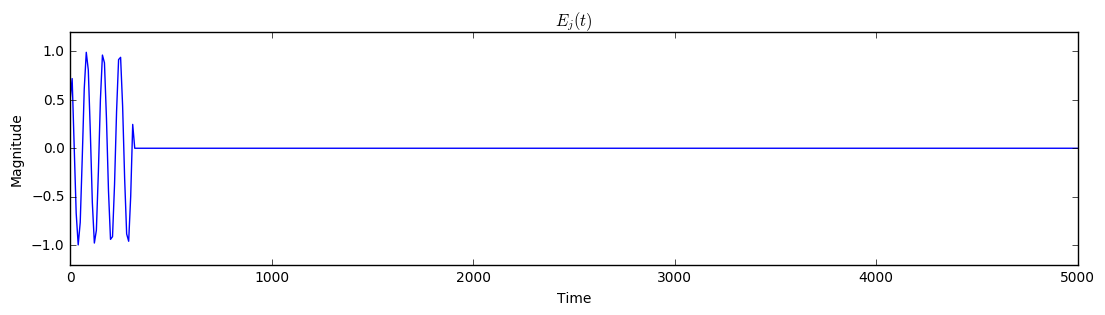

In [1142]:
time_c_func = lambdify({'a','b','t','st','w_rf', 'phi'},time_coeff,'numpy')
fig, ax = plt.subplots(1,1, figsize=(13,3))
ax.set_title('$E_j(t)$');
ax.plot(tlist, time_c_func(a=args['a'],b=args['b'],st=args['st'],w_rf=args['w_rf'],phi=args['phi'],t=tlist))
ax.set_ylim(-1.2,1.2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude');

# Operators definition

In [1143]:
def T(oper, qubit, N = N):
    if qubit == 1:
        return tensor(oper, identity(N[1]))
    else:
        return tensor(identity(N[0]), oper)
def THq(qubit,w = w):
    return 0.5*w[qubit-1]*T(sigmaz(),qubit)
def THint(wxx = wxx):
    return 0.5*wxx*tensor(sigmax(), sigmax())
def THf(qubit, ff=None):
    return (f[qubit-1] if ff==None else ff)*T(sigmax(),qubit)
def THsys_t(ff=f[0]):
    return [THq(1) + THq(2) + THint(),[THf(1,ff), time_coeff]]
anh = abs(w[0] - w[1])
def THsys_t_new():
    return wxx/4*(1/(1+anh**2/f[0]**2))*(1*tensor(sigmax(),sigmax()) + anh/f[0]*tensor(sigmaz(),sigmax()))

def TSx(qubit, N = N):
    return T(sigmax(),qubit, N)

def TSy(qubit, N = N):
    return T(sigmay(),qubit, N)

def TSz(qubit, N = N):
    return T(sigmaz(),qubit, N)

def TSp(qubit, N = N):
    return T(sigmap(),qubit, N)

def TSm(qubit, N = N):
    return T(sigmam(),qubit, N)

In [1144]:
THsys_t()

[Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
 Qobj data =
 [[ 34.87167845   0.           0.           0.07853982]
  [  0.          -3.45575192   0.07853982   0.        ]
  [  0.           0.07853982   3.45575192   0.        ]
  [  0.07853982   0.           0.         -34.87167845]],
 [Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
  Qobj data =
  [[ 0.          0.          0.43982297  0.        ]
   [ 0.          0.          0.          0.43982297]
   [ 0.43982297  0.          0.          0.        ]
   [ 0.          0.43982297  0.          0.        ]],
  'cos(w_rf*t + phi)*0.5*(tanh((t-a)/st) - tanh((t-b)/st))']]

# Visualisation

In [1145]:
def Tvis_out(output,every_t = 1):
    graphs = int(len(output.expect)/2)
    fig, axes2d = plt.subplots(graphs,2, figsize=(9,2*graphs), sharex=True)
    #axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['$\sigma_x(%d)$','$\sigma_y(%d)$','$\sigma_z(%d)$']
    colors = ["r","g","b","black","black","black","black","black","black"]
    for idx, axes in enumerate(axes2d):
        for idy, ax in enumerate(axes):
            #print("%d %d"%(idx,idy))
            ax.plot(tlist[::every_t], output.expect[idy*graphs + idx],linewidth=(2.5 if idy else 1.0),color=colors[idx], label=(labels[idx]%(idy) if idx <3 else "%d(%d)"%(idx-3,idy)) )
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.5,1.1)
            if idy == 1:
                ax.legend(bbox_to_anchor = [1,0],loc = "lower right")
            else:
                ax.legend(bbox_to_anchor = [1,1],loc = "upper right")
            if idx == graphs-1:
                ax.set_xlabel('Time')
            
def Tvis_out_print(output,every_t = 1):
    graphs = int(len(output.expect)/2)
    fig, axes = plt.subplots(1,2, figsize=(13,5), sharex=True)
    #axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['$\sigma_x(%d)$','$\sigma_y(%d)$','$\sigma_z(%d)$']
    for idx in range(graphs):
        for idy, ax in enumerate(axes):
            #print("%d %d"%(idx,idy))
            ax.plot(tlist[::every_t], output.expect[idy*graphs + idx], label=(labels[idx]%(idy) if idx <3 else "%d(%d)"%(idx-3,idy)) + " state")
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.5,1.1)
            ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
            ax.set_xlabel('Time')
                        

# Dynamics

In [1146]:
expected = []
Tpsi0 = tensor(basis(2,1), basis(2,1))
#Tpsi0 = tensor(basis(2,0)+basis(2,1), (basis(2,0) + basis(2,1)))/2
tlist = np.linspace(0,np.pi/wxx/f[0]*abs(w[0]-w[1]),timesteps)
t_gate = 1*np.pi/wxx/f[0]*abs(w[0]-w[1])
tlist = np.linspace(0,t_gate,timesteps)
def collapse_list():
    return []
def solve(expected_ops , Tpsi_0 =Tpsi0, with_progress_bar = None):
    if with_progress_bar:
        print(THsys_t())
        return mesolve(THsys_t(), Tpsi_0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=100000,rhs_reuse = True), progress_bar=True)
    else:
        print(THsys_t())
        return mesolve(THsys_t(), Tpsi_0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=100000,rhs_reuse = True), progress_bar=None)

In [1131]:
def get_pulse_operator():
    Tpsi = [tensor(basis(2,1), basis(2,1)), tensor(basis(2,1), basis(2,0)), tensor(basis(2,0), basis(2,1)), tensor(basis(2,0), basis(2,0))]
    Tpsi = list(reversed(Tpsi))
    #print(Tpsi)
    result = []
    for psi_id, Tpsi0 in enumerate(Tpsi):
        out = solve([],Tpsi0)
        state_final = out.states[-1]
        res_state = []
        #print(state_final)
        for Tpsi1 in Tpsi:
            res_state.append((Tpsi1.dag()*state_final).data.toarray()[0][0])
        result.append(res_state)
    #print(result)
    return Qobj(result).trans()

In [1149]:
op = get_pulse_operator()

[Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 34.87167845   0.           0.           0.07853982]
 [  0.          -3.45575192   0.07853982   0.        ]
 [  0.           0.07853982   3.45575192   0.        ]
 [  0.07853982   0.           0.         -34.87167845]], [Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.43982297  0.        ]
 [ 0.          0.          0.          0.43982297]
 [ 0.43982297  0.          0.          0.        ]
 [ 0.          0.43982297  0.          0.        ]], 'cos(w_rf*t + phi)*0.5*(tanh((t-a)/st) - tanh((t-b)/st))']]
[Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 34.87167845   0.           0.           0.07853982]
 [  0.          -3.45575192   0.07853982   0.        ]
 [  0.           0.07853982   3.45575192   0.        ]
 [  0.07853982   0.           0.         -34.87167845]],

In [970]:
def count_fidelity(ideal_gate, f):
    Tpsi = [tensor(basis(2,1), basis(2,1)), tensor(basis(2,1), basis(2,0)), tensor(basis(2,0), basis(2,1)), tensor(basis(2,0), basis(2,0))]
    Tpsi = list(reversed(Tpsi))
    #print(Tpsi)
    result = []
    t_gate = 1*np.pi/wxx/f*abs(w[0]-w[1])
    args['b'] = t_gate
    tlist = np.linspace(0,t_gate,2)
    for psi_id, Tpsi0 in enumerate(Tpsi):
        #print(THsys_t(f))
        out = mesolve(THsys_t(f), Tpsi0, tlist, [], [], args = args,options= Options(nsteps=1000000,rhs_reuse = True), progress_bar=None)
        state_final = out.states[-1]
        res_state = []
        #print(state_final)
        for Tpsi1 in Tpsi:
            res_state.append((Tpsi1.dag()*state_final).data.toarray()[0][0])
        result.append(res_state)
    gate = Qobj(result).trans()
    return gate

In [1061]:
gate = count_fidelity(ZX,0.05*2*np.pi)

In [1086]:
def for_solver(par):
    gate = count_fidelity(ZX,par[0])
    gate.dims = cnot().dims
    CNOT = ZI*gate*IX
    CNOT0 = CNOT.data.toarray()[0][0]
    CNOT = CNOT * CNOT0.conj()/abs(CNOT0)
    fid = min(fidelity(CNOT,cnot())/4,1)#,abs((cnot().dag()*CNOT).tr())/4)
    print(fid)
    return 1 - fid

In [1087]:
from scipy.optimize import fsolve

In [1088]:
res = fsolve(for_solver, [0.055*2*np.pi])

0.9925470663539258
0.9925470663539258
0.9925470663539258
0.992546335842311
0.24979728645695937
0.992391996772444
0.992546335842311
0.24979728645695937
0.992391996772444
0.9925598738452777
0.992531159359044
0.9925592847804188
0.9925600152798026
0.9925603782358592
0.9925592835956634
0.9925605333062916
0.9925598789688803
0.9925604914279533
0.9925604776529444
0.9925601339207832


In [1090]:
fs = np.linspace(0.01*2*np.pi,0.08*2*np.pi,8)
fid_list = []
for i, fi in enumerate(fs):
    gate = count_fidelity(ZX,fi)
    gate.dims = cnot().dims
    CNOT = ZI*gate*IX
    CNOT0 = CNOT.data.toarray()[0][0]
    CNOT = CNOT * CNOT0.conj()/abs(CNOT0)
    fid = (fidelity(CNOT,cnot())/4,abs((cnot().dag()*CNOT).tr())/4)
    fid_list.append(fid)
    print(i, fid)

0 (0.48360281669663485, 0.505915493414606)
1 (0.6953299451071697, 0.7380022059617154)
2 (0.6492290266273408, 0.2243411720237607)
3 (0.9667787356849985, 0.9445432476307616)
4 (0.9925165269627118, 0.9773989513200466)
5 (0.6744706292559732, 0.4221488691528196)
6 (0.46252961376089274, 0.5823636413916644)
7 (0.24988860572271585, 0.061441166599513375)


In [1079]:
fs[10]/2/np.pi

0.055

In [1059]:
gate0  =gate.data.toarray()[0][0]
gate = gate *gate0.conj()/abs(gate0)
gate.dims = ZX.dims
fid = (fidelity(gate,ZX)/4,abs((ZX.dag()*gate).tr())/4)

In [1060]:
fid

(0.39253888264560555, 0.020483925047338012)

In [1052]:
op

Quantum object: dims = [[4], [4]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[  1.91267838e-01+0.73966521j  -6.43140680e-01-0.01078697j
   -2.84770214e-04-0.03042439j  -3.70454014e-05+0.00077944j]
 [ -6.44447771e-01-0.00859704j  -2.12115970e-01+0.73486442j
    9.79444897e-06-0.01758058j   2.38802785e-04-0.03040538j]
 [ -2.38802557e-04-0.03040538j  -9.79445012e-06-0.01758058j
   -2.12115969e-01-0.73486442j  -6.44447771e-01+0.00859704j]
 [  3.70453975e-05+0.00077944j   2.84770336e-04-0.03042439j
   -6.43140680e-01+0.01078697j   1.91267847e-01-0.73966521j]]

In [1132]:
np.pi/wxx/f[0]*abs(w[0]-w[1])

366.6666666666665

In [1147]:
#t_gate = 355.01630
#t_gate = 1*np.pi/wxx/f[0]*abs(w[0]-w[1])
args['a'] = 0
args['b'] = args['a'] + t_gate
expected = [TSx(1),TSy(1),TSz(1),TSx(2),TSy(2),TSz(2)]
out = solve([])

[Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 34.87167845   0.           0.           0.07853982]
 [  0.          -3.45575192   0.07853982   0.        ]
 [  0.           0.07853982   3.45575192   0.        ]
 [  0.07853982   0.           0.         -34.87167845]], [Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.43982297  0.        ]
 [ 0.          0.          0.          0.43982297]
 [ 0.43982297  0.          0.          0.        ]
 [ 0.          0.43982297  0.          0.        ]], 'cos(w_rf*t + phi)*0.5*(tanh((t-a)/st) - tanh((t-b)/st))']]


In [1134]:
def observe(output, operators, rotationFreq , every = 1):
    output2 = copy.deepcopy(output)
    output2.expect = []
    for i in range(len(operators)*2):
        output2.expect.append([])
    num_operators = len(operators)
    for time, state in zip(tlist[::every], output.states[::every]):
#         time = tlist_t / timesteps * time_step
        for i, op in enumerate(operators):
            for qubit in [1,2]:
                if rotationFreq[qubit-1] != 0:
                    U = (sigmaz()*1j*rotationFreq[qubit-1]/2 * time).expm()
                    TU = T(U,qubit)
                    output2.expect[(qubit-1)*num_operators + i].append(expect(TU.dag()*op(qubit)*TU, state))
                else:
                    output2.expect[(qubit-1)*num_operators + i].append(expect(op(qubit), state))
    return output2

def observe_last(output, operators, rotationFreq):
    expectation = []
    time = tlist[-1]
    state = output.states[-1]
    for i, op in enumerate(operators):
        for qubit in [1,2]:
            if rotationFreq[qubit-1] != 0:
                U = (sigmaz()*1j*rotationFreq[qubit-1]/2 * time).expm()
                TU = T(U,qubit)
                expectation[(qubit-1)*num_operators + i].append(expect(TU.dag()*op(qubit)*TU, state))
            else:
                expectation[(qubit-1)*num_operators + i].append(expect(op(qubit), state))
    return expectation

In [1135]:
def find_T(sx,a=10,b=3000):
    return np.argmin(sx[a:b])+a
    

In [1136]:
find_T(output2.expect[0])

18

In [270]:
w1 = 2*np.pi/tlist[find_T(output2.expect[0])]

In [280]:
w2 = 2*np.pi/tlist[find_T(output2.expect[3],10, 1000)]

In [281]:
2*np.pi/w1,2*np.pi/w2

(2741.3706853426715, 2226.1130565282642)

In [18]:
w1 = 2*np.pi/2741.3706853426715
w2 = 2*np.pi/2226.1130565282642

In [132]:
%%time
#1 0
output2 = observe(out, [TSx, TSy, TSz], [w[0]-w1/2,w[1]+w2/2],1)
Tvis_out(output2,1)

KeyboardInterrupt: 

In [274]:
print(2*np.pi/w1, 2*np.pi/w2)

2741.37068534 1248.12406203


CPU times: user 16.6 s, sys: 8 ms, total: 16.6 s
Wall time: 16.6 s


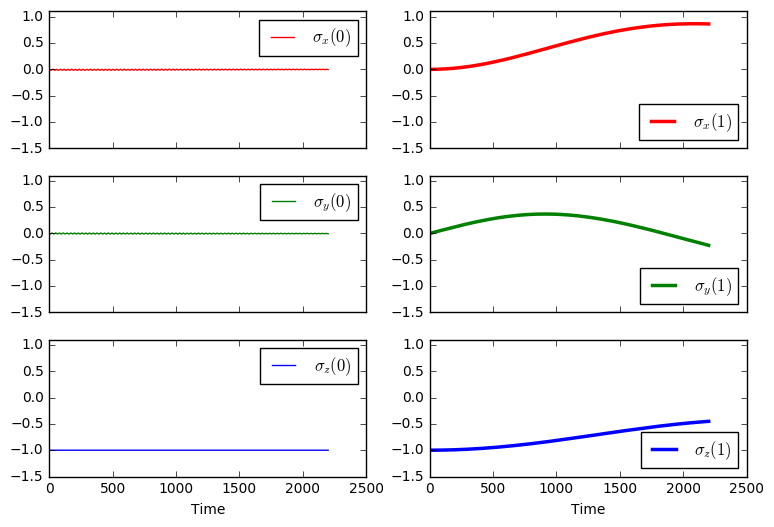

In [556]:
%%time
output2 = observe(out, [TSx, TSy, TSz], [w[0]-w1/2,w[1]+w2/2],1)
Tvis_out(output2,1)

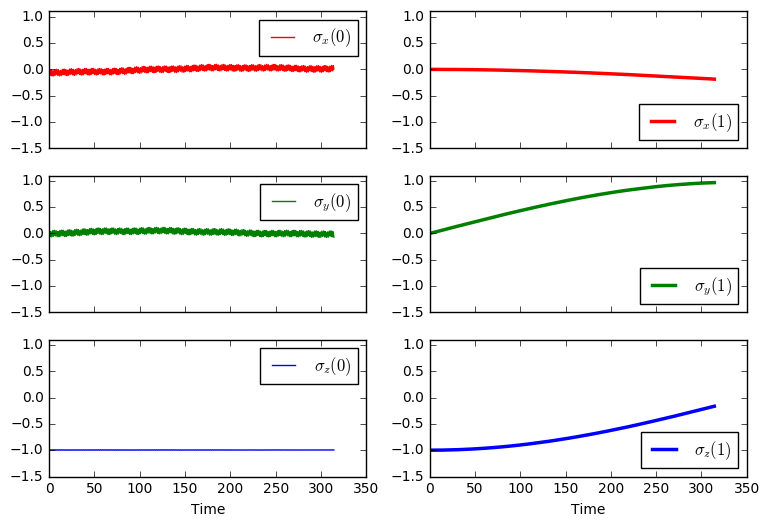

In [1148]:
#0 1
output2 = observe(out, [TSx, TSy, TSz], w,1)
Tvis_out(output2,1)

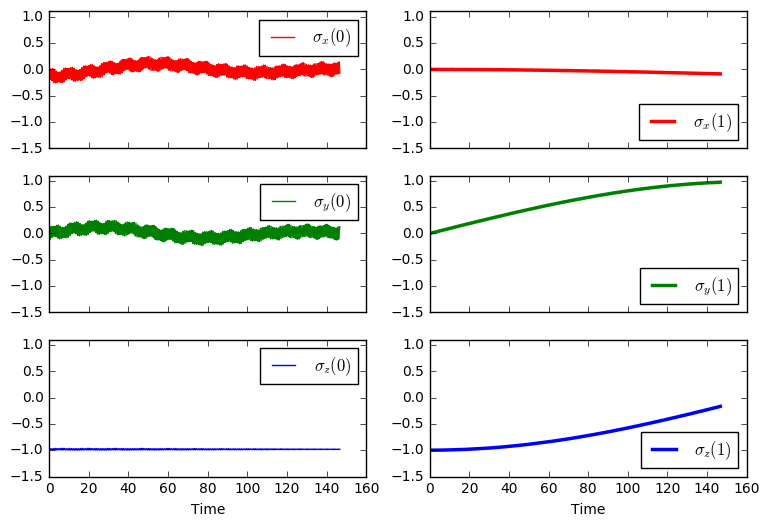

In [779]:
#0 0 
output2 = observe(out, [TSx, TSy, TSz], [w[0],w[1]],1)
Tvis_out(output2,1)

In [821]:
ZX = (+0.5*1j*1/2*np.pi*tensor(sigmaz(),sigmax())).expm()
ZX

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[ 0.70710678+0.j          0.00000000+0.70710678j  0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.70710678j  0.70710678+0.j          0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.70710678+0.j
   0.00000000-0.70710678j]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000-0.70710678j
   0.70710678+0.j        ]]

In [897]:
ZI = (0.5*1j*(+1/2)*np.pi*tensor(sigmaz(),identity(2))).expm()
ZI

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[ 0.70710678+0.70710678j  0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.70710678+0.70710678j  0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.70710678-0.70710678j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.70710678-0.70710678j]]

In [823]:
IX = (-0.5*1j*(+1/2)*np.pi*tensor(identity(2),sigmax())).expm()
IX

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[ 0.70710678+0.j          0.00000000-0.70710678j  0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000-0.70710678j  0.70710678+0.j          0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.70710678+0.j
   0.00000000-0.70710678j]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000-0.70710678j
   0.70710678+0.j        ]]

In [1150]:
op.dims = [[2,2],[2,2]]

In [1151]:
CNOT = ZI*op*IX
CNOT0 = CNOT.data.toarray()[0][0]

CNOT = CNOT * CNOT0.conj()/abs(CNOT0)

In [1152]:
CNOT

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[ 0.99031648+0.j         -0.09567199-0.08260998j -0.03160501-0.00265781j
  -0.02132481+0.0264979j ]
 [ 0.11547142+0.04617589j  0.44753305+0.88452794j -0.03735195-0.01350183j
  -0.02805324-0.0250416j ]
 [-0.02891929+0.02722393j -0.01580276+0.03412241j -0.08764090+0.08823228j
  -0.05949456+0.98951297j]
 [-0.02795097+0.01498946j -0.03009361-0.01585122j -0.90889036+0.39324934j
   0.05500164-0.11380843j]]

In [990]:
(CNOT.dag()*CNOT).tr()

4.0

In [1153]:
(CNOT+CNOT.conj())/2

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[ 0.99031648 -0.09567199 -0.03160501 -0.02132481]
 [ 0.11547142  0.44753305 -0.03735195 -0.02805324]
 [-0.02891929 -0.01580276 -0.0876409  -0.05949456]
 [-0.02795097 -0.03009361 -0.90889036  0.05500164]]

In [1156]:
Qobj(abs(CNOT))

Quantum object: dims = [[4], [4]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[ 0.99031648  0.12640229  0.03171656  0.03401303]
 [ 0.12436182  0.99129991  0.03971735  0.03760407]
 [ 0.03971735  0.03760407  0.12436182  0.99129991]
 [ 0.03171656  0.03401303  0.99031648  0.12640229]]

In [1155]:
abs((cnot().dag()*CNOT).tr())/4

0.5788459463107088

In [862]:
def true_fidelity(a,b):
    return (a.sqrtm()*b*a.sqrtm()).sqrtm().tr()

In [863]:
true_fidelity(CNOT,cnot())

(4.004595749646276+0.04600721375310049j)

In [1157]:
fidelity(CNOT,cnot())/4

0.4622947161887383

In [1159]:
CNOTa = Qobj(abs(CNOT))
CNOTa.dims = CNOT.dims

In [1161]:
fidelity(CNOTa,cnot())/4

0.9931191609500525

In [266]:
identity([2,2])

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]

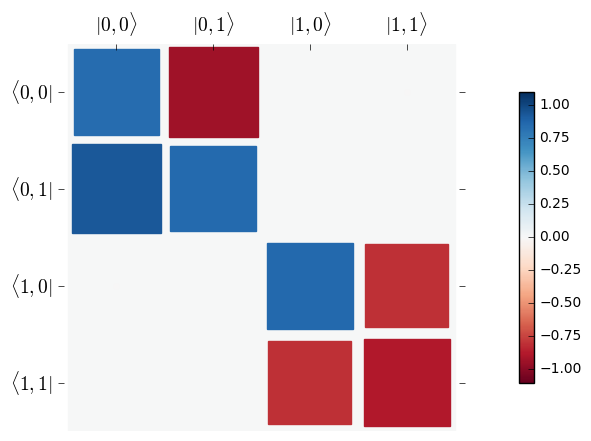

In [166]:
ax1 = plt.subplot(111)
hinton(real(CNOT),ax = ax1)
#ax2 = plt.subplot(122)
#hinton(Qobj(np.angle(CNOT.data.toarray())),ax = ax2)
plt.gcf().set_size_inches(7,5)
plt.savefig("CR CNOT diagram.pdf",bbox_inches = "tight")

In [60]:
CNOT

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000+0.j          0.12947982+0.00376285j -0.02090246-0.06948646j
  -0.01499066+0.0534877j ]
 [-0.12209009+0.00526564j  1.00073266-0.00702639j -0.00945660+0.06957701j
  -0.01914161-0.05817542j]
 [ 0.01063929+0.069406j    0.01814881-0.05849275j -0.12216202-0.00318716j
   1.00070732-0.01000501j]
 [ 0.01971692-0.06983212j  0.01589874+0.05322485j  0.99985518-0.01701792j
   0.12939703-0.00596579j]]

In [88]:
expect(TSz(2),ZX * Tpsi0)

-2.220446049250313e-16

In [180]:
new_t_list = np.linspace(0,2,100)
evolution = [(T(sigmaz(),1)*1j*2*np.pi/2 * t).expm()*Tpsi0 for t in new_t_list]

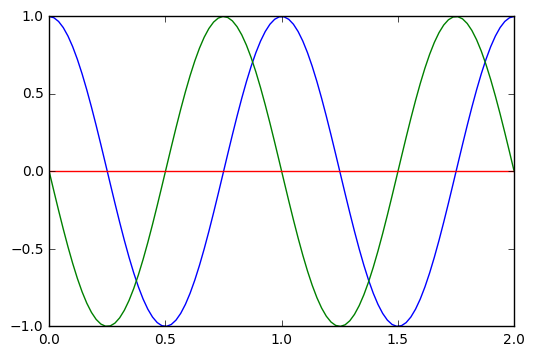

In [181]:
plt.plot(new_t_list, expect(TSx(1),evolution))
plt.plot(new_t_list, expect(TSy(1),evolution))
plt.plot(new_t_list, expect(TSz(1),evolution))


In [50]:
op

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.32873332-0.62666578j -0.51861731-0.47127485j  0.01953673-0.00820476j
  -0.08779763+0.00175506j]
 [-0.62146496-0.32284133j  0.46966567-0.52989318j -0.08449038+0.01830485j
   0.02654408-0.00196778j]
 [-0.02654408-0.00196778j  0.08449038+0.01830485j  0.46966567+0.52989318j
  -0.62146496+0.32284133j]
 [ 0.08779763+0.00175506j -0.01953673-0.00820476j -0.51861731+0.47127485j
   0.32873332+0.62666578j]]